# 1. 추천시스템 정의
- 아마존 등과 같은 전자상거래 업체로부터 넷플릭스, 유튜브,애플 뮤직 등 콘텐츠 포털까지 추천 시스템을 통해 사용자의 취향을 이해하고 맞춤 상품과 콘텐츠 제공해 조금이라도 오랫동안 자기 사이트에 고객이 머무르게 하기 위해 전력을 기울이고 있다.
- 추천시스템의 묘미는 사용자 자신도 좋아하는지 모르고 있었던 취향을 발견하는 것이다.
- 신뢰가 높아지면서 사용자는 추천 아이템을 더 많이 선택하게 되고, 더 많은 데이터가 추천 시스템에 추천되면서 추천이 정확해지고 다양해 진다.

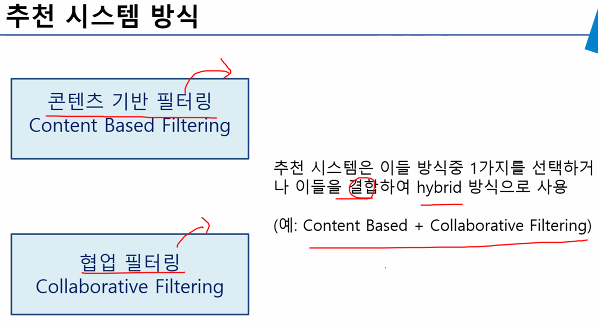

# 1-1. 아이템 기반 추천 (item based collaborative filtering)

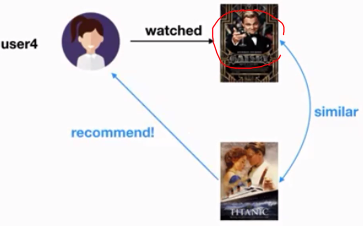

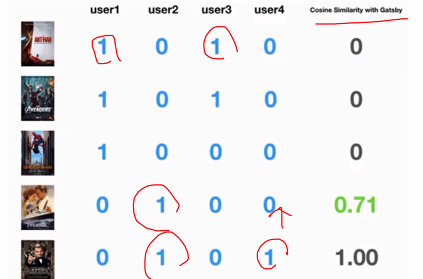

# 1-2. Contents based filtering (콘텐츠 기반 필터링)

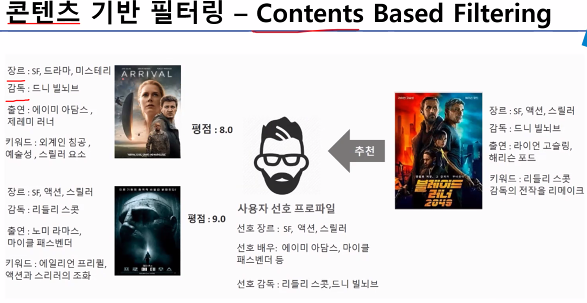

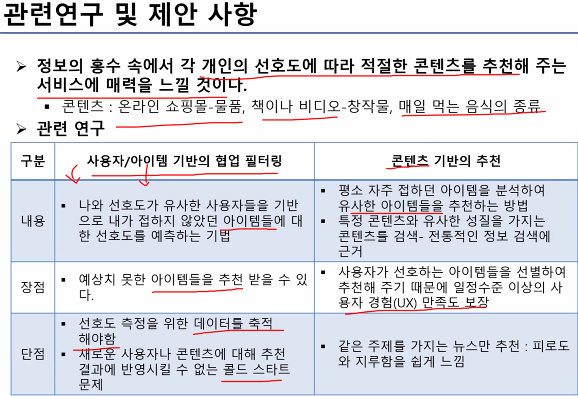

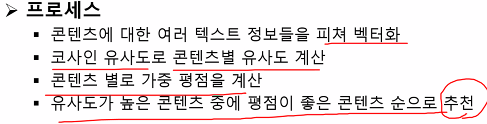

https://www.kaggle.com/tmdb/tmdb-movie-metadata

* id
* title : 제목
* genres : 영화 장르
* vote_average : 평균평점
* vote_count : 평점 카운트
* popularity : 인기도
* keywords : 영화의 키워드
* overview : 개요 설명


# 1. 데이터 로드

In [1]:
# 경고무시
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

movies = pd.read_csv('data/tmdb_5000_movies.csv')
movies.shape # 4803 x 20

(4803, 20)

In [3]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


# 2. feature 추출

In [4]:
movies_df = movies[['id','title','genres','vote_average','vote_count',
                   'popularity','keywords','overview']]
movies_df.head(1)

,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",7.2,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di..."


In [5]:
pd.set_option('max_colwidth',100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


## 2-1. genres와 keywords추출

In [6]:
movies_df['genres'].head(1)

0    [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {...
Name: genres, dtype: object

In [7]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [8]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


## 2-2. 장르 콘텐츠 필터링을 이용한 영화추천. 
- 장르 문자열을 count벡터화 후 코사인 유사도로 각 영화비교

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# countvectorizer를 적용하기 위해 공백문자로 word단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0
                            ,ngram_range=(1,2)) # 단어묶음을 1개부터 2개까지 보겠다 -> 옆에단어도 봄
genre_mat= count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape) # 4803 x 276

(4803, 276)


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape) # 4803 x 4803
print(genre_sim[:2]) # (1,1)-> 1이랑 1이만나는 유사도는 1  /  (1,2)이 만나는 유사도는 0.4

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


In [11]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1]) # genre_sim_sorted_ind[0]

[[   0 3494  813 ... 3038 3037 2401]]


## 2-4. 특정영화와 유사도가 높은 영화 반환

In [20]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    
    # 인자로 입력된 movies_df DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]
    
    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고 
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # 추출된 top_n index들 출력. top_n index는 2차원 데이터 임. 
    #dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]


In [21]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10) 
similar_movies[['title', 'vote_average']]
# similar_movies[['title', 'vote_average','weighted_vote']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


## 2-5. 평점이 높은 영화 정보 확인
- 10점줬는데 투표자가 1명인 영화도 있네?
- 투표자 수도 영향을 미치게 weighted rating을 주자.

**평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 계산  
         가중 평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * C**

         
* v: 개별 영화에 평점을 투표한 횟수 
* m: 평점을 부여하기 위한 최소 투표 횟수(ex.상위 60%, 40%)

* R: 개별 영화에 대한 평균 평점.
* C: 전체 영화에 대한 평균 평점


* 영화 평점(vote)와 관련 평균평점(vote_average) - 불공정
* 평점을 남긴 count(vote_count) 3개 - 다 5점
* vote가 많을수록 평점이 5점이 나올 수 없고, 떨어질 수 있다. 
* 참조 https://www.quora.com/How-does-IMDbs-rating-system-work


In [22]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average'
                                                             , ascending=False)[:10]


,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


#### 가중 평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * C

In [23]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:',round(m,3))

C: 6.092 m: 370.2


In [24]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C ) # 가중평점

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1) 


In [25]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]


,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [26]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]


,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


# 2-4. 개선

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values

    # top_n의 2배에 해당하는 장르 유사성이 높은 index추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    
    #기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote'
                                               ,ascending=False)[:top_n]


In [ ]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10) 
similar_movies[['title', 'vote_average','weighted_vote']]